# Определение возраста покупателей

**Описание проектной работы**

Сетевой супермаркет `«Хлеб-Соль»` внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

   - анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
   - контролировать добросовестность кассиров при продаже алкоголя.
   
   
**Цель проекта**

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Имеется в распоряжении набор фотографий людей с указанием возраста.
   

**Ход  выполнения проекта**
   

1. Исследовательский анализ набора фотографий.
2. Подготовка данных к обучению.
3. Обучение нейронной сети и рассчёт её качества. В качестве качественной метрики использование `МАЕ`, значение которой не должно превышать `8`.


# Содержание

[1. Исследовательский анализ данных](#Исследовательский-анализ-данных)
      
[2. Обучение модели](#Обучение-модели)

[3.  Анализ обученной модели](#Анализ-обученной-модели)

[4.  Итоговый вывод](#Итоговый-вывод)

## Исследовательский анализ данных

[Назад к содержанию](#Содержание)

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# загрузка исходной выборки:

labels = pd.read_csv('/datasets/faces/labels.csv')

# загрузка фотографий:

datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)


Found 7591 validated image filenames.


In [3]:
# вывод общей информации о датасете:

labels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# общая информация об исходном датасете:

labels.describe()


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
# размер выборки:

labels.shape


(7591, 2)

In [6]:
# вывод первых нескольких строк выборки:

labels.head()


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
# вывод последних нескольких строк выборки:

labels.tail()


,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


In [8]:
# проверим на дубликаты:

labels.duplicated().sum()


0

Явные дубликаты отсутствуют.

In [9]:
# проверка на пропуски:

labels.isna().sum()


file_name    0
real_age     0
dtype: int64

Пропуски в данных отсутствуют.

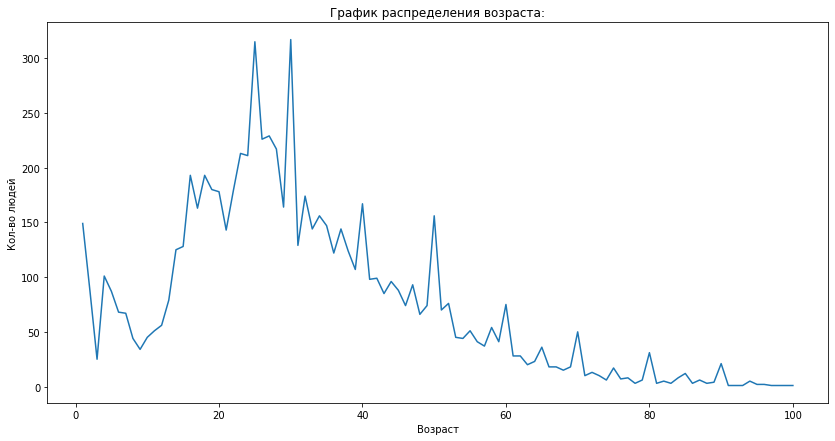

In [10]:
# график распределения возраста в выборке:

plt.figure(figsize=(14,7))
labels['real_age'].value_counts().sort_index(ascending=False).plot(
     kind='line')

plt.xlabel('Возраст')
plt.ylabel('Кол-во людей')

plt.title('График распределения возраста:')

plt.show()


По графику сделаем выводы:

   - выбросов данных не наблюдаем;
   - средний возраст людей на фотографиях равен 29 лет;
   - выделяется два пика с количеством фотографий людей с возрастом приблизительно 28 и 32 года;
   - количество людей в возрасте около 18 лет не так много - это может сказаться на точности предсказания возраста детей при продаже алкоголя.
   

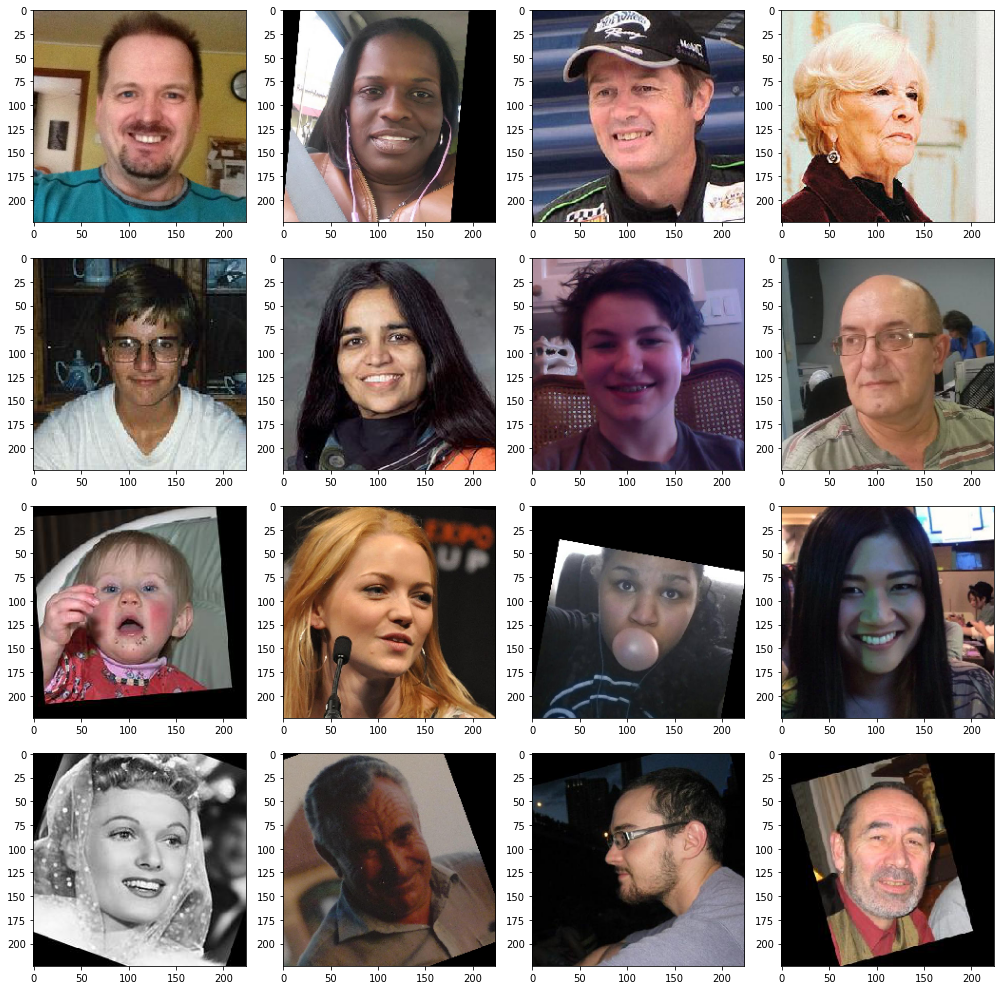

In [11]:
# вывод 15 фотографий:

fig = plt.figure(figsize=(14,14))

for i in range(16):
    fig.add_subplot(4, 4, i + 1) 
    plt.imshow(datagen_flow[0][0][i])

    plt.tight_layout()


**Выводы**

На фото наблюдаем лица людей. В предоставленном датасете представлены мужчины, женщины и дети. Размер большинства выведенных фотографий одинаковый 224х224. Тем не менее, встречаются фотографии, отличные от квадратной формы. Большинство фотографий цветные, встречаются и черно-белые фото. Также можно отметить, что некоторые фотографии повернуты. Похоже на то, что уже была проведена первичная обработка изображений.

## Обучение модели

[Назад к содержанию](#Содержание)

Обучим модель для прогнозирования возраста человека по фотографии. Для этого применим архитектуру нейронной сети `ResNet50`.  

Для обучения модели создадим следующие функции:

   1) `load_train()` - для загрузки тренировочной выборки с фотографиями;
   
   2) `load_test()` - для загрузки тестовой выборки;
   
   3) `create_model()` - функция для создания модели. В функции будет задана архитектура сети: будут выбраны необходимые слои, количество нейронов, функция активации, скорость обучения, будет задана функция потерь и искомая метрика. Также будет выполнена компиляция модели. 
   
   Архитектура сети `ResNet50` выбрана со следующими характеристиками:
     
   - `50-слойная` модель `ResNet50`;
   - предзагруженные веса модели `ResNet50`: 
   `'/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'`;
   - в качестве первого слоя использовали слой `GlobalAveragePooling2D`;
   - в качестве последнего слоя задействован полносвязный слой `Dense` с одним нейроном и функцией активации `ReLu`. `ReLu` выбран поскольку у нас стоит задача регрессии;
   - алгоритм оптимизации `Adam` со скоростью обучения `0.0001`;
   - функция потерь - среднеквадратичная ошибка (`MSE`);
   - искомая метрика - средняя абсолютная ошибка (`MAE`). По условию задания необходимо получить МАЕ менее `8`.
       
   4) `train_model()` - функция обучения модели. Выбрано `5 эпох` для обучения.
   

Ниже предоставлен код обучения модели. 

Сама модель обучалась на отдельном сервере с GPU-процессором. Код представлен в виде текстовой ячейки. Поэтому при попытке запуска код не сработает. 

Также приведен результат выполнения кода.

```python

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

import pandas as pd
import numpy as np

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
          rescale=1./255,
          validation_split=0.2
          )

    train_gen_flow = train_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='training',
          seed=12345) 

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.2
      )

    test_gen_flow = test_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='validation',
          seed=12345) 

    return test_gen_flow

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)  

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(
    model,
    train_datagen_flow,
    test_data_flow,
    batch_size=None,
    epochs=5,
    steps_per_epoch=None,
    validation_steps=None
    ):
  
    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_data_flow) 

    model.fit_generator(
      train_datagen_flow,
      validation_data=test_data_flow,
      epochs=epochs,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps,
      verbose=2,
      shuffle=True
  )

    return model
    

```

Результат обучения:

```

Train for 190 steps, validate for 48 steps
Epoch 1/5
2023-05-18 21:55:06.916442: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-18 21:55:07.218232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 74s - loss: 213.3194 - mae: 10.5055 - val_loss: 894.3839 - val_mae: 24.9099
Epoch 2/5
190/190 - 39s - loss: 60.0006 - mae: 5.8846 - val_loss: 911.9279 - val_mae: 25.2109
Epoch 3/5
190/190 - 39s - loss: 30.3128 - mae: 4.2247 - val_loss: 220.5173 - val_mae: 10.9357
Epoch 4/5
190/190 - 39s - loss: 20.5562 - mae: 3.5211 - val_loss: 94.4439 - val_mae: 7.2914
Epoch 5/5
190/190 - 40s - loss: 16.0736 - mae: 3.1040 - val_loss: 70.0162 - val_mae: 6.3178
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 70.0162 - mae: 6.3178
Test MAE: 6.3178

```

## Анализ обученной модели

[Назад к содержанию](#Содержание)

Модель обучилась на 5 эпохах. Значение `MAE` получилось равным `6.3178`, что удовлетворяет поставленной задаче.

Значение `МАЕ` `6.3` означает, что модель ошибается в среднем на `6` лет. 

В связи с этим можно сделать следующие выводы:
   
   - модель предсказывает ориентировочный возраст покупателей;
   - модель ошибается примерно на `6 лет`;
   - для предсказания возраста детей данную модель лучше не использовать.

## Итоговый вывод

[Назад к содержанию](#Содержание)

В данной работе была построена модель машинного обучения для предсказания приблизительного возраста покупателя по его фотографии. В проекте были выполнены следующие задачи:
    
   - проведен исследовательский анализ набора фотографий;
   - были подготовлены данные для последующего обучения модели;
   - была обучена нейронная сеть `ResNet50`;
   - было рассчитано качество модели.
   
Полученная модель ошибается ориентировочно на `6 лет`. Поэтому:

   - модель можно использовать для анализа покупок, совершенных покупателями различных возрастных групп. В связи с погрешностью прогнозирования модели, возрастные группы необходимо разбить как минимум на `10 лет`;
   - для контроля добросовестности кассиров при продаже алкоголя полученную модель лучше не применять в связи с большой погрешностью определения возраста;
   - поставленная в задаче метрика `МАЕ` (менее 8 лет) достигнута.
   